In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df1 = pd.read_csv("Chennai_Weather.csv")
df1.head()

,Date,Time,Temp,Hum
0,2021-09-01,0,82.0,84.0
1,2021-09-01,1,82.0,84.0
2,2021-09-01,2,82.0,86.5
3,2021-09-01,3,82.0,89.0
4,2021-09-01,4,84.0,79.0


In [3]:
df2 = pd.read_csv("VIT_Solar_Power_hourly.csv")
df2.head()

,Date,Hour,Irradiance,Power
0,2021-09-01,0,0,0.0
1,2021-09-01,1,0,0.0
2,2021-09-01,2,0,0.0
3,2021-09-01,3,0,0.0
4,2021-09-01,4,0,0.0


In [4]:
df3=pd.merge(df2, df1, left_index=True, right_index=True)
df3.head()

,Date_x,Hour,Irradiance,Power,Date_y,Time,Temp,Hum
0,2021-09-01,0,0,0.0,2021-09-01,0,82.0,84.0
1,2021-09-01,1,0,0.0,2021-09-01,1,82.0,84.0
2,2021-09-01,2,0,0.0,2021-09-01,2,82.0,86.5
3,2021-09-01,3,0,0.0,2021-09-01,3,82.0,89.0
4,2021-09-01,4,0,0.0,2021-09-01,4,84.0,79.0


In [5]:
df3.shape

(8736, 8)

In [6]:
df3 = df3.drop("Date_y",axis=1)
df3.rename(columns={'Date_x': 'Date'}, inplace=True)
df3.head()

,Date,Hour,Irradiance,Power,Time,Temp,Hum
0,2021-09-01,0,0,0.0,0,82.0,84.0
1,2021-09-01,1,0,0.0,1,82.0,84.0
2,2021-09-01,2,0,0.0,2,82.0,86.5
3,2021-09-01,3,0,0.0,3,82.0,89.0
4,2021-09-01,4,0,0.0,4,84.0,79.0


In [7]:
df3 = df3.drop("Time",axis=1)

In [8]:
df3.shape

(8736, 6)

In [9]:
df3.isnull().sum()

Date          0
Hour          0
Irradiance    0
Power         0
Temp          0
Hum           0
dtype: int64

In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8736 entries, 0 to 8735
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        8736 non-null   object 
 1   Hour        8736 non-null   int64  
 2   Irradiance  8736 non-null   int64  
 3   Power       8736 non-null   float64
 4   Temp        8736 non-null   float64
 5   Hum         8736 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 477.8+ KB


In [11]:
df3['Date']=pd.to_datetime(df3['Date'])

In [12]:
df3.head()

,Date,Hour,Irradiance,Power,Temp,Hum
0,2021-09-01,0,0,0.0,82.0,84.0
1,2021-09-01,1,0,0.0,82.0,84.0
2,2021-09-01,2,0,0.0,82.0,86.5
3,2021-09-01,3,0,0.0,82.0,89.0
4,2021-09-01,4,0,0.0,84.0,79.0


In [13]:
df3=df3.drop(["Date","Hour"],axis=1)

In [14]:
df3 = df3.reset_index(drop=True)

In [15]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
      
  agg = concat(cols, axis=1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace=True)
  return agg
 

 
# load dataset
values = df3.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1        0.0        0.0   0.796117   0.868132  0.000000  0.000000  0.796117   
2        0.0        0.0   0.796117   0.868132  0.000000  0.000000  0.796117   
3        0.0        0.0   0.796117   0.890110  0.000000  0.000000  0.796117   
4        0.0        0.0   0.796117   0.923077  0.000000  0.000000  0.815534   
5        0.0        0.0   0.815534   0.774725  0.001902  0.001902  0.841748   

    var4(t)  
1  0.868132  
2  0.890110  
3  0.923077  
4  0.774725  
5  0.725275  


In [16]:
...
# split into train and test sets
values = reframed.values
n_train_hours = 250 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6000, 1, 7) (6000,) (2735, 1, 7) (2735,)


In [17]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [18]:
scaler_X.fit(train)
scaler_y.fit(test)

MinMaxScaler()

In [19]:
...
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
84/84 - 10s - loss: 0.3807 - val_loss: 0.1593 - 10s/epoch - 115ms/step
Epoch 2/50
84/84 - 1s - loss: 0.1626 - val_loss: 0.1420 - 514ms/epoch - 6ms/step
Epoch 3/50
84/84 - 1s - loss: 0.1335 - val_loss: 0.1217 - 538ms/epoch - 6ms/step
Epoch 4/50
84/84 - 0s - loss: 0.1082 - val_loss: 0.1003 - 368ms/epoch - 4ms/step
Epoch 5/50
84/84 - 0s - loss: 0.0852 - val_loss: 0.0823 - 336ms/epoch - 4ms/step
Epoch 6/50
84/84 - 0s - loss: 0.0673 - val_loss: 0.0691 - 417ms/epoch - 5ms/step
Epoch 7/50
84/84 - 0s - loss: 0.0586 - val_loss: 0.0638 - 358ms/epoch - 4ms/step
Epoch 8/50
84/84 - 0s - loss: 0.0563 - val_loss: 0.0622 - 412ms/epoch - 5ms/step
Epoch 9/50
84/84 - 0s - loss: 0.0559 - val_loss: 0.0610 - 473ms/epoch - 6ms/step
Epoch 10/50
84/84 - 0s - loss: 0.0555 - val_loss: 0.0612 - 419ms/epoch - 5ms/step
Epoch 11/50
84/84 - 0s - loss: 0.0554 - val_loss: 0.0611 - 423ms/epoch - 5ms/step
Epoch 12/50
84/84 - 0s - loss: 0.0555 - val_loss: 0.0619 - 426ms/epoch - 5ms/step
Epoch 13/50
84/84 - 0s -

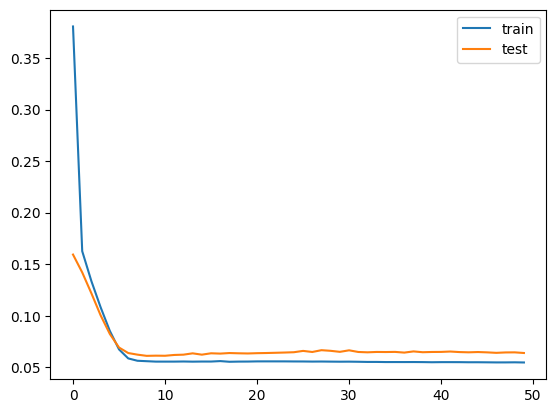

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

86/86 [==============================] - 1s 2ms/step


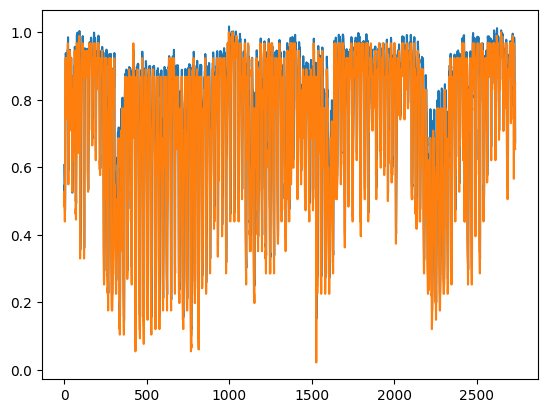

In [22]:
y_pred = model.predict(test_X)

# plotting test data
pyplot.plot(y_pred)
pyplot.plot(test_y)

In [23]:
# Calculate R2
r2 = r2_score(test_y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, y_pred))

# Calculate MSE
mse = mean_squared_error(test_y, y_pred)

# Calculate MAE
mae = mean_absolute_error(test_y, y_pred)

# Calculate adjusted R2
n = len(test_y)
p = 1  # assuming only one predictor variable
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# Print results
print(f"R2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Adjusted R2: {r2_adj:.3f}")

R2: 0.840
RMSE: 0.092
MSE: 0.008
MAE: 0.064
Adjusted R2: 0.840


In [24]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df3[['Irradiance', 'Temp', 'Hum']])
Y_data = Y_scaler.fit_transform(df3[['Power']]) 

In [25]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y)

In [26]:
hist_window = 48
horizon = 
TRAIN_SPLIT = 6000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 

In [27]:
 print('Multiple window of past history\n')
 print(x_train[0])
 print('\n Target horizon\n')
 print(y_train[0])

Multiple window of past history

[[0.         0.7961165  0.84      ]
 [0.         0.7961165  0.84      ]
 [0.         0.7961165  0.865     ]
 [0.         0.7961165  0.89      ]
 [0.         0.81553398 0.79      ]
 [0.00190156 0.84174757 0.76      ]
 [0.00387625 0.87087379 0.687     ]
 [0.02128282 0.89320388 0.645     ]
 [0.03759234 0.88349515 0.645     ]
 [0.08132816 0.86407767 0.725     ]
 [0.25422365 0.86407767 0.705     ]
 [0.62619762 0.84466019 0.7       ]
 [0.55971623 0.82524272 0.765     ]
 [0.61120456 0.83495146 0.74      ]
 [0.4123455  0.83495146 0.74      ]
 [0.34059826 0.82524272 0.765     ]
 [0.30381043 0.81553398 0.79      ]
 [0.10517077 0.81553398 0.79      ]
 [0.02325751 0.80582524 0.79      ]
 [0.         0.7961165  0.84      ]
 [0.         0.7961165  0.84      ]
 [0.         0.7961165  0.84      ]
 [0.         0.7961165  0.84      ]
 [0.         0.7961165  0.84      ]
 [0.         0.7961165  0.79      ]
 [0.         0.78640777 0.84      ]
 [0.         0.7961165  0.765  

In [28]:
import tensorflow as tf

batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

In [40]:
lstm_model = tf.keras.models.Sequential([
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 48, 400)          326400    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 48, 20)            8020      
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 20)                6020      
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)               

In [41]:
tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
history = lstm_model.fit(train_data,epochs=15,steps_per_epoch=100,validation_data=val_data,validation_steps=50)

Epoch 1/15
100/100 [==============================] - 14s 58ms/step - loss: 0.0353 - val_loss: 0.0195
Epoch 2/15
100/100 [==============================] - 4s 35ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 3/15
100/100 [==============================] - 4s 35ms/step - loss: 0.0146 - val_loss: 0.0184
Epoch 4/15
100/100 [==============================] - 4s 37ms/step - loss: 0.0138 - val_loss: 0.0128
Epoch 5/15
100/100 [==============================] - 4s 35ms/step - loss: 0.0124 - val_loss: 0.0099
Epoch 6/15
100/100 [==============================] - 4s 36ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 7/15
100/100 [==============================] - 4s 37ms/step - loss: 0.0129 - val_loss: 0.0271
Epoch 8/15
100/100 [==============================] - 4s 36ms/step - loss: 0.0119 - val_loss: 0.0333
Epoch 9/15
100/100 [==============================] - 4s 36ms/step - loss: 0.0121 - val_loss: 0.0382
Epoch 10/15
100/100 [==============================] - 4s 36ms/step - loss: 0.0128 - val_l

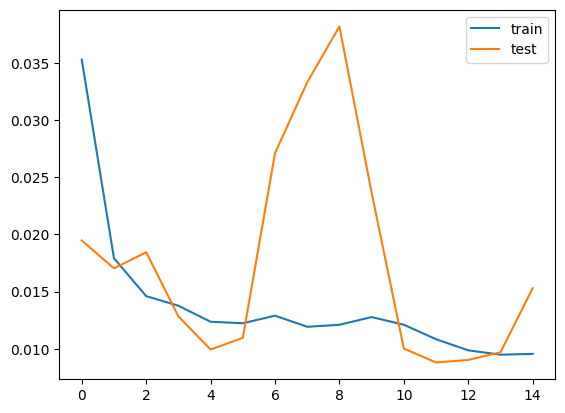

In [42]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
y_pred

array([[0.22501825],
       [0.23263054],
       [0.24266312],
       ...,
       [0.23510687],
       [0.25686187],
       [0.25870693]], dtype=float32)

In [49]:
y_vali.shape

(2678, 10, 1)

In [54]:
y_vali[1].max()

0.20310100197469466

In [65]:
actual_y = []
for i in range(0,2678):
  actual_y.append(y_vali[i].max())

84/84 [==============================] - 0s 4ms/step


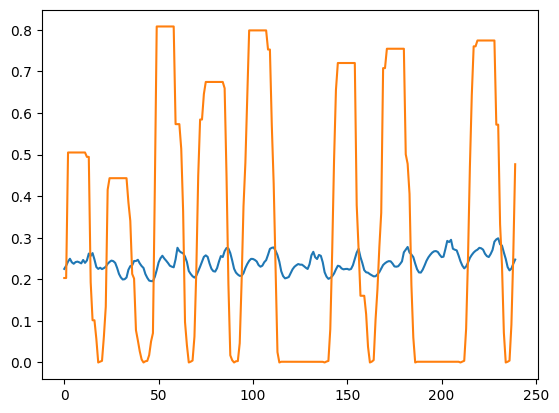

In [69]:
y_pred = model.predict(x_vali)


# plotting test data
pyplot.plot(y_pred[:240])
pyplot.plot(actual_y[:240])

In [70]:
# Calculate R2
r2 = r2_score(actual_y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_y, y_pred))

# Calculate MSE
mse = mean_squared_error(actual_y, y_pred)

# Calculate MAE
mae = mean_absolute_error(actual_y, y_pred)

# Calculate adjusted R2
n = len(actual_y)
p = 1  # assuming only one predictor variable
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# Print results
print(f"R2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Adjusted R2: {r2_adj:.3f}")

R2: -0.401
RMSE: 0.343
MSE: 0.117
MAE: 0.300
Adjusted R2: -0.402
